Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import matplotlib.pyplot as plt

from distribution import pmf_from_seq

### The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

First, let's see how to do the update.

### The prior

If we know nothing about the probability of winner, we could start with a uniform prior.

In [72]:
def decorate_bandit(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of winning')
    plt.ylabel('PMF')
    plt.title(title)

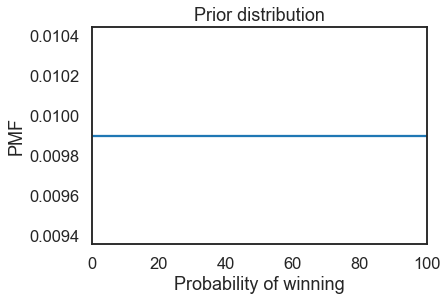

In [73]:
bandit = pmf_from_seq(range(101))
bandit.plot()
decorate_bandit('Prior distribution')

### The likelihood function

To do an update, we need a likelihood function that computes the probability of an outcome (W or L) for a hypothetical value of x, the probability of winning.

**Exerecise:** Fill in the likelihood function for this scenario.  Note that `hypo` is in the range 0 to 100.

In [76]:
def likelihood_bandit(data, hypo):
    """Likelihood function for Bayesian bandit
    
    data: string, either 'W' or 'L'
    hypo: probability of winning (0-100)
    
    returns: float probability
    """
    # TODO: fill this in!
    return 1

In [77]:
# Solution

def likelihood_bandit(data, hypo):
    """Likelihood function for Bayesian bandit
    
    data: string, either 'W' or 'L'
    hypo: probability of winning (0-100)
    
    returns: float probability
    """
    x = hypo / 100
    if data == 'W':
        return x
    else:
        return 1-x

Now we can update with a single loss:

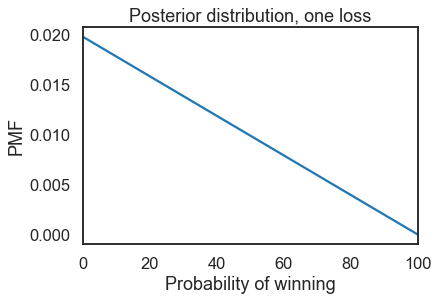

In [10]:
bandit.update(likelihood_bandit, 'L')
bandit.plot()
decorate_bandit('Posterior distribution, one loss')

Another loss:

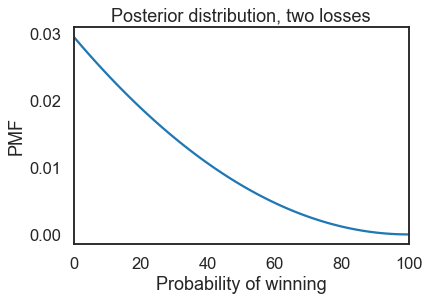

In [11]:
bandit.update(likelihood_bandit, 'L')
bandit.plot()
decorate_bandit('Posterior distribution, two losses')

And a win:

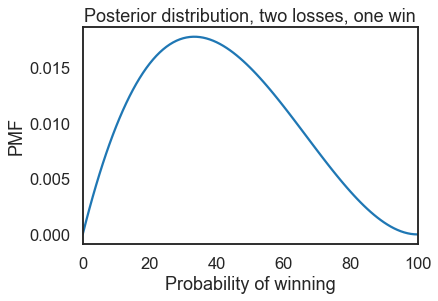

In [12]:
bandit.update(likelihood_bandit, 'W')
bandit.plot()
decorate_bandit('Posterior distribution, two losses, one win')

Starting over, here's what it looks like after 1 win and 9 losses.

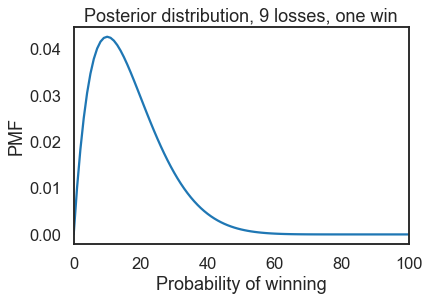

In [13]:
bandit = pmf_from_seq(range(101))

for outcome in 'WLLLLLLLLL':
    bandit.update(likelihood_bandit, outcome)

bandit.plot()
decorate_bandit('Posterior distribution, 9 losses, one win')

The posterior mean is about 17%

In [14]:
bandit.mean()

16.68194469884906

The most likely value is the observed proportion 1/10

In [15]:
bandit.MAP()

10

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [17]:
bandit.credible_interval(0.9)

array([ 3., 36.])

## Multiple bandits

Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities:

In [18]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

The following function simulates playing one machine once.

In [19]:
from random import random
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def flip(p):
    """Return True with probability p."""
    return random() < p

def play(i):
    """Play machine i.
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if flip(p):
        return 'W'
    else:
        return 'L'

Here's a test, playing machine 3 twenty times:

In [20]:
for i in range(20):
    result = play(3)
    print(result, end=' ')

L L W L L W L W L W W L L L W L L W L W 

Now I'll make 4 `Pmf` objects to represent our beliefs about the 4 machines.

In [21]:
prior = range(101)
beliefs = [pmf_from_seq(prior) for i in range(4)]

This function displays the four posterior distributions

In [56]:
options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    sns.set_context('paper')
    for i, b in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        b.plot(label='Machine %s' % i)
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()
    sns.set_context('talk')

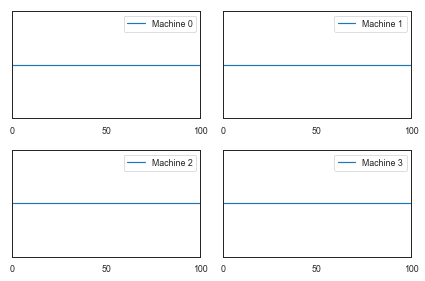

In [57]:
plot(beliefs)

Now suppose we play each machine 10 times.  This function updates our beliefs about one of the machines based on one outcome.

In [78]:
def update(beliefs, i, outcome):
    """Update beliefs about machine i, given outcome.
    
    beliefs: list of Pmf
    i: index into beliefs
    outcome: string 'W' or 'L'
    """
    beliefs[i].update(likelihood_bandit, outcome)

**Exercise:** Write a nested loop that plays each machine 10 times, then plot the posterior distributions.  Hint: call `play` and then `update`.

In [79]:
# Solution

for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs, i, outcome)

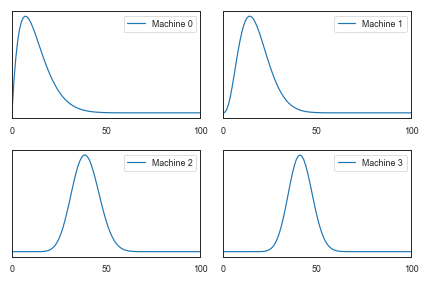

In [80]:
# Solution

plot(beliefs)

After playing each machine 10 times, we have some information about their probabilies:

In [61]:
[belief.mean() for belief in beliefs]

[25.00001236675582, 16.68194469884906, 49.99999999999999, 50.0]

## Bayesian Bandits

To get more information, we could play each machine 100 times, but while we are gathering data, we are not making good use of it.  The kernel of the Bayesian Bandits algorithm is that is collects and uses data at the same time.  In other words, it balances exploration and exploitation.

The following function chooses among the machines so that the probability of choosing each machine is proportional to its "probability of superiority".

`random` chooses a value from the posterior distribution.

`argmax` returns the index of the machine that chose the highest value.

In [64]:
def choose(beliefs):
    """Use the Bayesian bandit strategy to choose a machine.
    
    Draws a sample from each distributions.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

Here's an example.

In [65]:
choose(beliefs)

2

Putting it all together, the following function chooses a machine, plays once, and updates `beliefs`:

In [66]:
def choose_play_update(beliefs, verbose=False):
    """Chose a machine, play it, and update beliefs.
    
    beliefs: list of Pmf objects
    verbose: Boolean, whether to print results
    """
    
    i = choose(beliefs)
    outcome = play(i)
    update(beliefs, i, outcome)
    if verbose:
        print(i, outcome, beliefs[i].mean())

Here's an example

In [67]:
counter = Counter()
choose_play_update(beliefs, verbose=True)

2 L 46.15384615485771


## Trying it out

Let's start again with a fresh set of machines:

In [68]:
beliefs = [pmf_from_seq(prior) for i in range(4)]

Now we can play a few times and see how `beliefs` gets updated:

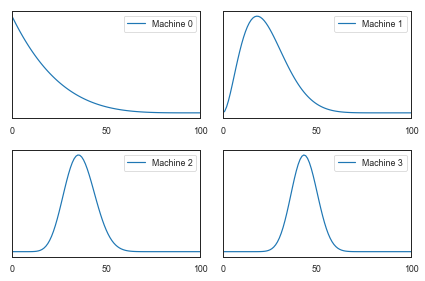

In [69]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

We can summarize `beliefs` by printing the posterior mean and credible interval:

In [70]:
for i, b in enumerate(beliefs):
    print(b.mean(), b.credible_interval(0.9))

16.25345499309617 [ 1. 45.]
23.076939985507135 [ 7. 44.]
36.111111111111114 [24. 50.]
43.39622641509435 [32. 55.]


The credible intervals usually contain the true values (10, 20, 30, and 40).

The estimates are still rough, especially for the lower-probability machines.  But that's a feature, not a bug: the goal is to play the high-probability machines most often.  Making the estimates more precise is a means to that end, but not an end itself.

Let's see how many times each machine got played.  If things go according to play, the machines with higher probabilities should get played more often.

In [71]:
for machine, count in sorted(counter.items()):
    print(machine, count)

0 4
1 11
2 35
3 51


**Exercise:**  Go back and run this section again with a different value of `num_play` and see how it does.